# Project 2: Mini deep-learning framework

In [1]:
#!/usr/bin/env python3
""" File to solve the second miniproject which is the design of a framework """

import cProfile

import math
import random
import matplotlib
import matplotlib.pyplot as plt

import torch

__author__ = 'Eugène Lemaitre, Natalie Bolón Brun, Louis Munier'
__version__ = '0.1'

torch.set_grad_enabled(False)

# Data generation and plotting

In [2]:
def generate_disc_set(nb):
    """Function to generate nb data like follow:
    
    It generates nb points uniformly distributed in the domain [0,1]x[0,1] and set the class as:
     - 1 if the point is in the radius 1/(2*pi)^(1/2)
     - 0 otherwise
    """
    X = torch.empty(nb,2).uniform_(0,1)
    Y = torch.empty(X.size())
    
    Y[:,0] = ((X - 0.5).norm(dim=1)  >  math.sqrt(1/(2*math.pi))).type(torch.LongTensor)
    Y[:,1] = ((X - 0.5).norm(dim=1)  <=  math.sqrt(1/(2*math.pi))).type(torch.LongTensor)
    
    return X, Y

def plot_disc(data_in, data_target, title):
    """Function to plot the generated data and their classes."""

    plt.scatter(data_in[(data_target[:,1]==1),0] ,data_in[(data_target[:,1]==1),1], color = "c", s=20)
    plt.scatter(data_in[(data_target[:,1]==0),0] ,data_in[(data_target[:,1]==0),1], color = "g", s=20)
    plt.title(title)
    plt.legend(["1", "0"] )
    plt.show()

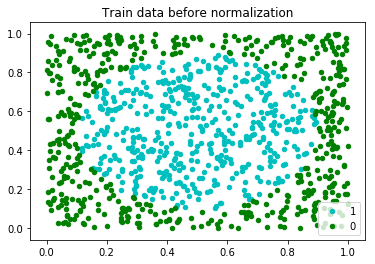

Point outside:  520
Point inside:   480


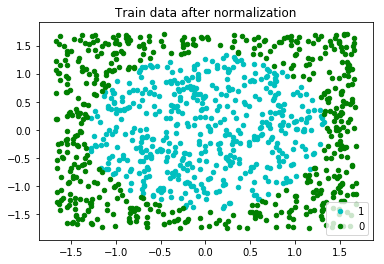

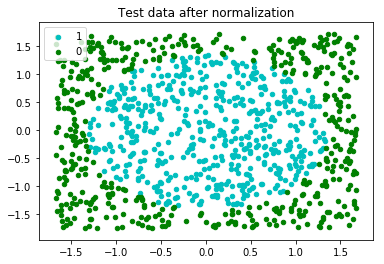

In [3]:
Sample_number = 1000
train_input, train_target = generate_disc_set(Sample_number)
test_input, test_target = generate_disc_set(Sample_number)

plot_disc(train_input, train_target, "Train data before normalization")
    
print("Point outside: ", train_input[(train_target[:,1]==0),0].size(0))
print("Point inside:  ", train_input[(train_target[:,1]==1),0].size(0))

mu, std = train_input.mean(0), train_input.std(0)
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

plot_disc(train_input, train_target, "Train data after normalization")
plot_disc(test_input, test_target, "Test data after normalization")

# Module

In [4]:
class Module():
    """Parent class defining a DLN"""
    
    def forward(self, *input):
        raise NotImplementedError('Module : forward function is not implemented')

    def backward(self, *gradwrtoutput):
        raise NotImplementedError('Module : backward function is not implemented')

    def param(self):
        return []

## Linear

In [5]:
class Linear(Module):
    def __init__(self, dim_in, dim_out, dropout=None):
        self.x = torch.empty((0,0))
        self.s = torch.empty((0,0))
        
        self.dim_in = dim_in
        self.dim_out = dim_out
        
        self.bias = torch.empty(1, dim_out)
        self.weight = torch.empty(dim_out, dim_in)
            
        self.gradwrtbias = torch.empty((0,0))
        self.gradwrtweight = torch.empty((0,0))
        
        if dropout:
            if dropout > 1 or dropout < 0:
                raise ValueError('Linear : Dropout must be a percentage value (comprise between 0 and 1)')
            else:
                self.dropout = dropout*100
        else:
            self.dropout = dropout
                
        self.dropout_mask = torch.empty((0,0))
    
    def forward(self, *input):
        self.x = input[0]
        self.s = self.x.mm(self.weight.t()) + self.bias
        
        if self.dropout :
            self.update_dropout()
            return self.s * self.dropout_mask
        else :
            return self.s

    def backward(self, *gradwrtoutput):
        self.gradwrtbias = torch.ones(1, self.x.size(dim=0)).mm(gradwrtoutput[0])
        self.gradwrtweight = gradwrtoutput[0].t().mm(self.x)
        
        return gradwrtoutput[0].mm(self.weight)
        
    def param(self):
        return [self.bias, self.weight]
        
    def define_parameters(self, weight, bias):
        if weight.size() != (self.dim_out, self.dim_in):
            raise ValueError('Linear : weight size must match ({}, {})'.format(self.dim_out, self.dim_in))
        else:
            self.weight = weight
            
        if bias.size() != (1, self.dim_out):
            raise ValueError('Linear : bias size must match ({}, {})'.format(1, self.dim_out))
        else:
            self.bias = bias
        
    def normalize_parameters(self, mean, std):
        self.bias = self.bias.normal_(mean=mean, std=std)
        self.weight = self.weight.normal_(mean=mean, std=std)
        
    def update_parameters(self, eta):
        self.bias -= eta * self.gradwrtbias
        self.weight -= eta * self.gradwrtweight
        
    def update_dropout(self):
        self.dropout_mask = torch.randint(101, self.s.size())
        self.dropout_mask = (self.dropout_mask >= self.dropout).type(torch.FloatTensor)

## Loss

In [6]:
class Loss(Module):
    def __init__(self):
        output = torch.empty((0,0))
        target_output = torch.empty((0,0))
    
    def forward(self, *input):
        self.output = input[0]
        self.target_output = input[1]

    def backward(self, *gradwrtoutput):
        raise NotImplementedError('Loss : backward function is not implemented')

    def param(self):
        return []

### MSE

In [7]:
class LossMSE(Loss):
    def __init__(self):
        Loss.__init__(self)
        
    def forward(self, output, target_output):
        Loss.forward(self, output, target_output)
        loss = (self.output - self.target_output).pow(2).mean()  # (dim=0).sum()
        return loss

    def backward(self):
        return 2*(self.output - self.target_output)/self.output.numel()  # size(dim=0)

    def param(self):
        return []

### Cross Entropy

In [161]:
class CrossEntropy(Loss):
    def __init__(self):
        Loss.__init__(self)
    
    def forward(self, output, target_output):
        Loss.forward(self, output, target_output)
        loss =  -1./self.output.size(dim=0) * (self.output[ (torch.arange(0, self.output.size(dim=0) )).type(torch.long), self.target_output].sum() - self.output.exp().sum(dim=1).log().sum() ) 
        return loss
        
    def backward_old(self):
        grad = torch.empty(self.output.size())
        for i in range(0, self.output.size(dim=0)):
            grad[i,:] = self.output[i,:].exp().div_(self.output[i,:].exp().sum())
            
        grad[(torch.arange(0, self.output.size(dim=0))).type(torch.long), self.target_output] -= 1
        grad.div_(self.output.size(dim=0))
        return grad
        
    def backward(self):
        grad = self.output.exp().div_(self.output.exp().sum(dim=1).expand(self.output.t().size()).t())
            
        grad[list(range(0, self.output.size(dim=0))), self.target_output] -= 1
        grad.div_(self.output.size(dim=0))
        return grad
            
    def param(self):
        return []

## Activations

In [9]:
class Activation(Module):
    def __init__(self):
        self.s = torch.empty((0,0))

    def forward(self, *input):
        raise NotImplementedError('Activation : forward function is not implemented')

    def backward(self, *gradwrtoutput):
        raise NotImplementedError('Activation : backward function is not implemented')

    def param(self):
        return []

### Tanh

In [10]:
class Tanh(Activation):
    def __init__(self):
        Activation.__init__(self)
        
    def forward(self, x):
        self.s = x
        return x.tanh()

    def backward(self, *gradwrtoutput):
        return (1 - (self.s.tanh()).pow(2)) * (gradwrtoutput[0])
        
    def param(self):
        return []

### ReLU

In [108]:
class Relu(Activation):
    def __init__(self):
        Activation.__init__(self)
    
    def forward_old(self, x):
        self.s = x
        
        y = torch.empty(self.s.size()).zero_()
        y[x>0] = x[x>0]
        
        return y
    
    def forward(self, x):
        self.s = x
        y = torch.empty(self.s.size()).zero_()
        return torch.max(x, y)

    def backward_old(self, *gradwrtoutput):
        y = torch.empty(gradwrtoutput[0].size()).zero_()
        y[self.s > 0] = gradwrtoutput[0][self.s > 0]
        
        return y
    
    def backward(self, *gradwrtoutput):
        y = torch.empty(gradwrtoutput[0].size()).zero_()
        return (torch.eq(y, torch.min(y, self.s))).type(torch.FloatTensor).mul(gradwrtoutput[0])

    def param(self):
        return []

### Sigmoid

In [68]:
class Sigmoid(Activation):
    def __init__(self, p_lambda):
        Activation.__init__(self)
        self.p_lambda = p_lambda
    
    def forward(self, x):
        self.s = x
        return 1/(1 + torch.exp(-self.p_lambda*x))

    def backward(self, *gradwrtoutput):
        return torch.exp(-self.s * self.p_lambda) / (torch.exp(-self.s * self.p_lambda) + 1).pow(2) * (gradwrtoutput[0])

    def param(self):        
        return []

## Optimizers

In [19]:
class Optimizers():
    def __init__(self):
        self.s = torch.empty((0,0))
        
    def __call__(self):
        raise NotImplementedError('Optimizers : __call__ function is not implemented')

    def param(self):
        return []

### SGD

In [20]:
class Sgd(Optimizers):
    def __init__(self):
        Optimizers.__init__(self)

    def __call__(self, *input, eta=0.1):
        for l in input[0]:
            if isinstance(l, Linear):
                l.bias -= eta * l.gradwrtbias
                l.weight -= eta * l.gradwrtweight

    def param(self):
        return []

### Decreasing lr - works

In [21]:
class DecreaseSGD(Optimizers):
    def __init__(self):
        Optimizers.__init__(self)

    def __call__(self, epoch, *input, eta=0.1, beta=0.1):
        for l in input[0]:
            if isinstance(l, Linear):
                l.bias -= eta/((1+beta*epoch)) * l.gradwrtbias
                l.weight -= eta/((1+beta*epoch)) * l.gradwrtweight


    def param(self):
        return []

# Sequential

In [56]:
class Sequential(Module):
    """Child class of Module, create a DLN by giving a sequence of layers"""
    
    def __init__(self, *sequence, loss=None):
        self.sequence = []
        
        if not loss:
            raise ValueError('Wrong argument given to Sequential a loss function must be given.')
        else:
            self.loss = loss
        
        for i, arg in enumerate(sequence):
            if isinstance(arg, Linear) and i%2 == 0:
                self.sequence.append(arg)
            elif isinstance(arg, Activation) and i%2 == 1:
                self.sequence.append(arg)
            else:
                if i%2 == 0:
                    raise ValueError('Wrong argument given to Sequential a Linear layer was expected as argument {}.'.format(i+1))
                elif isinstance(arg, Loss) and i != len(sequence):
                    raise ValueError('Wrong argument given to Sequential the loss must be the last argument given.')
                else:
                    raise ValueError('Wrong argument given to Sequential an Activation function was expected as argument {}.'.format(i+1))
                    
    def forward(self, x):
        for step in self.sequence:
            x = step.forward(x)
        return x

    def backward(self):
        grad = self.loss.backward()
        for step in reversed(self.sequence):
            grad = step.backward(grad)
    
    def param(self):
        return []
    
    def compute_loss(self, output, target_output):
        if type(self.loss) == CrossEntropy:
            return self.loss.forward(output, target_output.argmax(dim=1))
        else:
            return self.loss.forward(output, target_output)
    
    def normalize_parameters(self, mean, std):
        for step in reversed(self.sequence):
            if isinstance(step, Linear) and step.param() != []:
                step.normalize_parameters(mean, std)
                
    def update_parameters(self, eta):
        for step in reversed(self.sequence):
            if step.param() != []:
                step.update_parameters(eta)

### Compute number error

In [23]:
def compute_number_error(output_one_hot, target_one_hot):
    output = output_one_hot.argmax(dim=1)
    target = target_one_hot.argmax(dim=1)
    nb_of_error = (output != target).sum()
    return nb_of_error

# Test 

In [171]:
# Model definition:
hidden_nb = 25

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=loss) 
    
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000

model.normalize_parameters(mean=0, std=std)
optimizer = DecreaseSGD()

pr = cProfile.Profile()
pr.enable()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model.forward(train_input.narrow(0, b, batch_size))
        
        loss_value =  model.compute_loss(output, train_target.narrow(0, b, batch_size))
        model.backward()
        
        optimizer(epochs, model.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
        eta = eta*0.95
        
pr.disable()
pr.print_stats(sort="calls")

0 :  0.69359290599823
50 :  0.6745538711547852
100 :  0.6286167502403259
150 :  0.5238678455352783
200 :  0.38124701380729675
250 :  0.27088481187820435
300 :  0.21233443915843964
350 :  0.1790441870689392
400 :  0.157856285572052
450 :  0.1431933492422104
500 :  0.13253143429756165
550 :  0.12438033521175385
600 :  0.11786315590143204
650 :  0.11266341805458069
700 :  0.10834304243326187
750 :  0.10475952178239822
800 :  0.10174728184938431
850 :  0.09917480498552322
900 :  0.09693725407123566
950 :  0.09500045329332352
         591779 function calls in 5.063 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    80000    0.841    0.000    0.841    0.000 {method 'mm' of 'torch._C._TensorBase' objects}
    75000    0.075    0.000    0.075    0.000 {method 'size' of 'torch._C._TensorBase' objects}
    50000    0.140    0.000    0.140    0.000 {method 't' of 'torch._C._TensorBase' objects}
    35120    0.008    0.000    0.008    0.

In [ ]:
# Train set: 

output = model.forward(train_input)
l = model.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")

# print(output[0:10,:])
# print(test_target[0:10,:])

In [ ]:
#Train set plot
id_class = output.argmax(dim=1)

one_id_as_one = torch.mul( (train_target[:,1]==1), (id_class ==1 ))
one_id_as_zero = torch.mul( (train_target[:,1]==1), (id_class ==0 ))
zero_id_as_one = torch.mul( (train_target[:,1]==0), (id_class ==1 ))
zero_id_as_zero = torch.mul( (train_target[:,1]==0), (id_class ==0 ))

plt.scatter(train_input[one_id_as_one,0] ,train_input[one_id_as_one,1], color = "c", s=20)
plt.scatter(train_input[zero_id_as_zero,0] ,train_input[zero_id_as_zero,1], color = "g", s=20)
plt.scatter(train_input[one_id_as_zero,0] ,train_input[one_id_as_zero,1], color = "r", s=20)
plt.scatter(train_input[zero_id_as_one,0] ,train_input[zero_id_as_one,1], color = "y", s=20)

plt.title("Result on train data")
plt.legend(["1 id as 1", "0 id as 0", "1 id as 0", "0 id as 1"] )
plt.show()

In [ ]:
# Test set: 

output = model.forward(test_input)
l = model.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")

# print(output[0:10,:])
# print(test_target[0:10,:])

In [ ]:
#Test set plot
id_class = output.argmax(dim=1)

one_id_as_one = torch.mul( (test_target[:,1]==1), (id_class ==1 ))
one_id_as_zero = torch.mul( (test_target[:,1]==1), (id_class ==0 ))
zero_id_as_one = torch.mul( (test_target[:,1]==0), (id_class ==1 ))
zero_id_as_zero = torch.mul( (test_target[:,1]==0), (id_class ==0 ))

plt.scatter(test_input[one_id_as_one,0] ,test_input[one_id_as_one,1], color = "c", s=20)
plt.scatter(test_input[zero_id_as_zero,0] ,test_input[zero_id_as_zero,1], color = "g", s=20)
plt.scatter(test_input[one_id_as_zero,0] ,test_input[one_id_as_zero,1], color = "r", s=20)
plt.scatter(test_input[zero_id_as_one,0] ,test_input[zero_id_as_one,1], color = "y", s=20)

plt.title("Result on test data")
plt.legend(["1 id as 1", "0 id as 0", "1 id as 0", "0 id as 1"] )
plt.show()

## Comparison Test

### Without autograd

In [169]:
# Model definition:
hidden_nb = 25

pr = cProfile.Profile()
pr.enable()

linear_1 = Linear(2, hidden_nb, dropout=0.2)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb, dropout=0.2)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb, dropout=0.3)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
relu_4 = Relu()

model = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, relu_4, loss=CrossEntropy()) 
    
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000
my_loss = []

model.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model.compute_loss(output, train_target.narrow(0, b, batch_size))
        model.backward()
        optimizer(model.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
        eta = eta*0.95
        
    my_loss.append(loss_value.item())
        
pr.disable()
pr.print_stats(sort="calls")

0 :  0.6931470632553101
50 :  0.6931470632553101
100 :  0.6931470632553101
150 :  0.6931470632553101
200 :  0.6931470632553101
250 :  0.6931470632553101
300 :  0.6931470632553101
350 :  0.6931470632553101
400 :  0.6931470632553101
450 :  0.6931470632553101
500 :  0.6931470632553101
550 :  0.6931470632553101
600 :  0.6931470632553101
650 :  0.6931470632553101
700 :  0.6931470632553101
750 :  0.6931470632553101
800 :  0.6931470632553101
850 :  0.6931470632553101
900 :  0.6931470632553101
950 :  0.6931470632553101
         724020 function calls in 8.026 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   100000    0.106    0.000    0.106    0.000 {method 'size' of 'torch._C._TensorBase' objects}
    80000    1.021    0.000    1.021    0.000 {method 'mm' of 'torch._C._TensorBase' objects}
    50000    0.158    0.000    0.158    0.000 {method 't' of 'torch._C._TensorBase' objects}
    40140    0.010    0.000    0.010    0.000 {built

### With autograd

In [170]:
import torch.nn as nn

from torch.autograd import Variable
from torch.nn import functional as F

torch.set_grad_enabled(True)
train_input = Variable(train_input.data, requires_grad=True)

hidden_nb = 25

pr = cProfile.Profile()
pr.enable()

linear_1 = nn.Linear(2, hidden_nb)
relu_1 = nn.ReLU()
linear_2 = nn.Linear(hidden_nb, hidden_nb)
relu_2 = nn.ReLU()
linear_3 = nn.Linear(hidden_nb, hidden_nb)
relu_3 = nn.ReLU()
linear_4 = nn.Linear(hidden_nb, 2)
relu_4 = nn.ReLU()

dropout_1 = nn.Dropout(0.2)
dropout_2 = nn.Dropout(0.3)
model = nn.Sequential(linear_1, dropout_1, relu_1, linear_2, dropout_1, relu_2, linear_3, dropout_2, relu_3, linear_4, relu_4)
dropout_1.training
dropout_2.training

#new_train_target = train_target.max(1)[1]
criterion = nn.CrossEntropyLoss()

std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000
grad_loss = []
        
for epochs in range(epochs_number):
    # set model to training mode
    model.train(True)
        
    for b in range(0, Sample_number, batch_size):
        output = model.forward(train_input.narrow(0, b, batch_size))
        loss_value = criterion(output, train_target.narrow(0, b, batch_size).argmax(dim=1))
        
        model.zero_grad()
        loss_value.backward()

        for p in model.parameters():
            p.data.sub_(eta * p.grad.data)
        
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
        eta = eta*0.95
    
    grad_loss.append(loss_value.item())

torch.set_grad_enabled(False)

pr.disable()
pr.print_stats(sort="calls")

0 :  0.6827918291091919
50 :  0.1917957365512848
100 :  0.1364545375108719
150 :  0.1205335259437561
200 :  0.09533006697893143
250 :  0.11312443763017654
300 :  0.06829845160245895
350 :  0.03850498050451279
400 :  0.09036578983068466
450 :  0.05434734374284744
500 :  0.04917245730757713
550 :  0.06509440392255783
600 :  0.03926070034503937
650 :  0.04819801449775696
700 :  0.05124785378575325
750 :  0.037462249398231506
800 :  0.015907621011137962
850 :  0.06360897421836853
900 :  0.01462895143777132
950 :  0.02185574546456337
         2490188 function calls (2270188 primitive calls) in 9.611 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
330000/120000    0.344    0.000    0.387    0.000 module.py:938(named_modules)
   231000    0.035    0.000    0.035    0.000 {method 'items' of 'collections.OrderedDict' objects}
   200000    0.070    0.000    0.101    0.000 {method 'add' of 'set' objects}
   160000    0.026    0.000    0.

In [ ]:
import numpy as np
def plot_results(errors, str_results):
    xdata = np.arange(0, 1000)

    plt.figure(str_results)
    plt.title(str_results)
    plt.xlabel('Epochs [-]')
    plt.ylabel('Errors [%]')

    plt.plot(xdata, errors, 'r')

In [ ]:
plot_results(my_loss, 'My loss')
plot_results(grad_loss, 'Auto-grad loss')

xdata = np.arange(0, 1000)
plt.figure('Both loss')
plt.plot(xdata, my_loss, 'r')
plt.plot(xdata, grad_loss, 'b')